In [1]:
import csv
import pickle
import strip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm, trange
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Parameters

TILE_SIZE = 20

In [87]:
import extract

input_list = extract.load_and_strip('./test/_DONEIN700-SN142.csv')
del input_list[len(input_list) - 1]
for i, row in enumerate(input_list):
    input_list[i] = input_list[i][2:9]

print(len(input_list))

174258it [00:03, 52742.47it/s]

174257


In [4]:
## Dumping
# p_file = open('./test.p', 'wb')

# pickle.dump(output, p_file)

## Loading
# recover = open('./test.p', 'rb')
# b = pickle.load(recover)
# print(len(b))

In [88]:
cancer_cells = []
T_cells = []
cyto_T_cells = []

for i, row in enumerate(input_list):
    row = [ int(x) for x in row ]
    
    if row[4] > 0:
        cancer_cells.append([row[0], row[1], row[2], row[3]])
    if row[5] > 0:
        T_cells.append([row[0], row[1], row[2], row[3]])
    if row[6] > 0:
        cyto_T_cells.append([row[0], row[1], row[2], row[3]])
        
cancer_cells = np.asarray(cancer_cells)
T_cells = np.asarray(T_cells)
cyto_T_cells = np.asarray(cyto_T_cells)

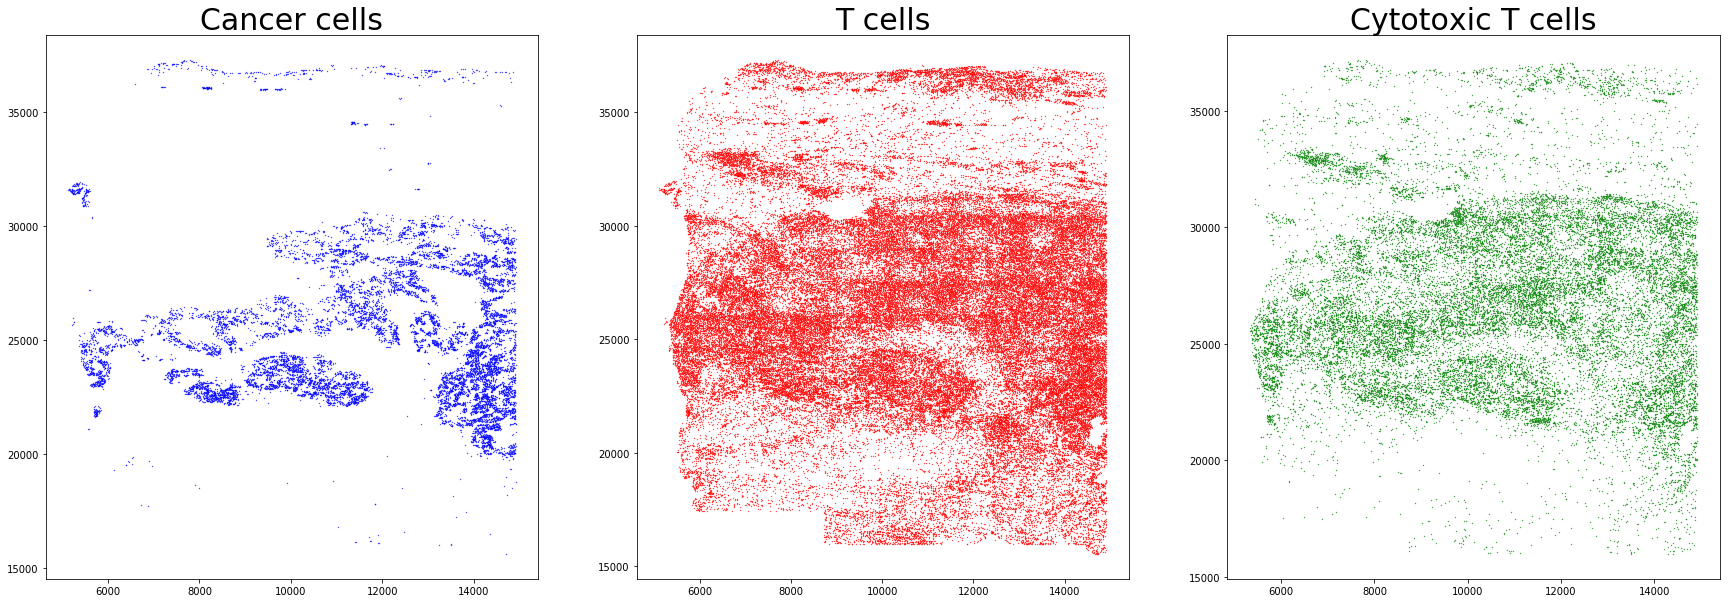

In [89]:
cancer_cells_xAvg = np.mean(np.array([cancer_cells[:,0], cancer_cells[:,1]]), axis=0)
cancer_cells_yAvg = np.mean(np.array([cancer_cells[:,2], cancer_cells[:,3]]), axis=0)

T_cells_xAvg = np.mean(np.array([T_cells[:,0], T_cells[:,1]]), axis=0)
T_cells_yAvg = np.mean(np.array([T_cells[:,2], T_cells[:,3]]), axis=0)

cyto_T_cells_xAvg = np.mean(np.array([cyto_T_cells[:,0], cyto_T_cells[:,1]]), axis=0)
cyto_T_cells_yAvg = np.mean(np.array([cyto_T_cells[:,2], cyto_T_cells[:,3]]), axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

ax1.set_title('Cancer cells', fontsize=30)
ax1.scatter(cancer_cells_xAvg, cancer_cells_yAvg, s=0.1, c='b')

ax2.set_title('T cells', fontsize=30)
ax2.scatter(T_cells_xAvg, T_cells_yAvg, s=0.1, c='r')

ax3.set_title('Cytotoxic T cells', fontsize=30)
ax3.scatter(cyto_T_cells_xAvg, cyto_T_cells_yAvg, s=0.1, c='g')

plt.show()

In [90]:
output_image = np.zeros((220, 100), dtype=np.int)
output_image = np.uint8(np.stack((output_image, output_image, output_image), 2)*255)

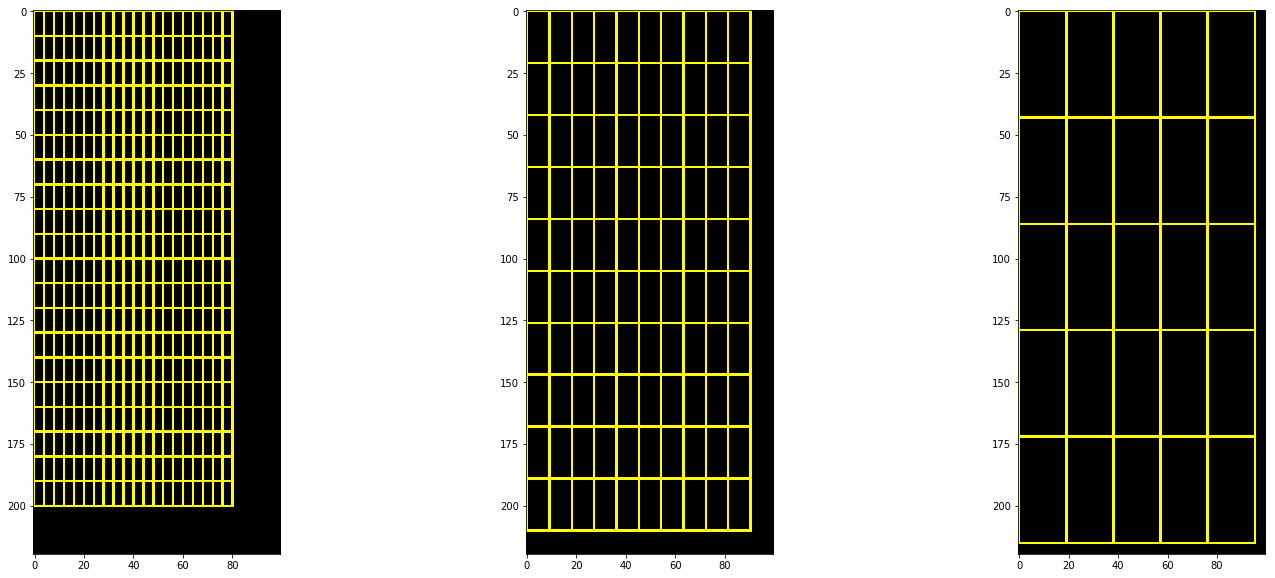

In [91]:
import cv2

def visualise_tiles(image, num_tiles, draw_image):
    xMin = image[:,0]
    xMax = image[:,1]
    yMin = image[:,2]
    yMax = image[:,3]

    # Just scaling this down so that we don't have to work with ENORMOUS images
    x_step = int(((max(xMax) / 10) - (min(xMin) / 10)) // (num_tiles * 10))
    y_step = int(((max(yMax) / 10) - (min(yMin) / 10)) // (num_tiles * 10))
        
    for i in range(num_tiles):
        for j in range(num_tiles):
            x_left, y_left = x_step * i, y_step * (j + 1)
            x_right, y_right = x_step * (i + 1), y_step * j
            cv2.rectangle(draw_image, (x_left, y_left), (x_right, y_right), (255, 255, 0), 1)
    
    return draw_image

copy1 = np.copy(output_image)
copy2 = np.copy(output_image)
copy3 = np.copy(output_image)

out1 = visualise_tiles(cancer_cells, 20, copy1)
out2 = visualise_tiles(cancer_cells, 10, copy2)
out3 = visualise_tiles(cancer_cells, 5, copy3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))

ax1.imshow(out1)
ax2.imshow(out2)
ax3.imshow(out3)

plt.show()

100%|██████████| 20/20 [00:00<00:00, 480.57it/s]
13804it [00:12, 1077.44it/s]


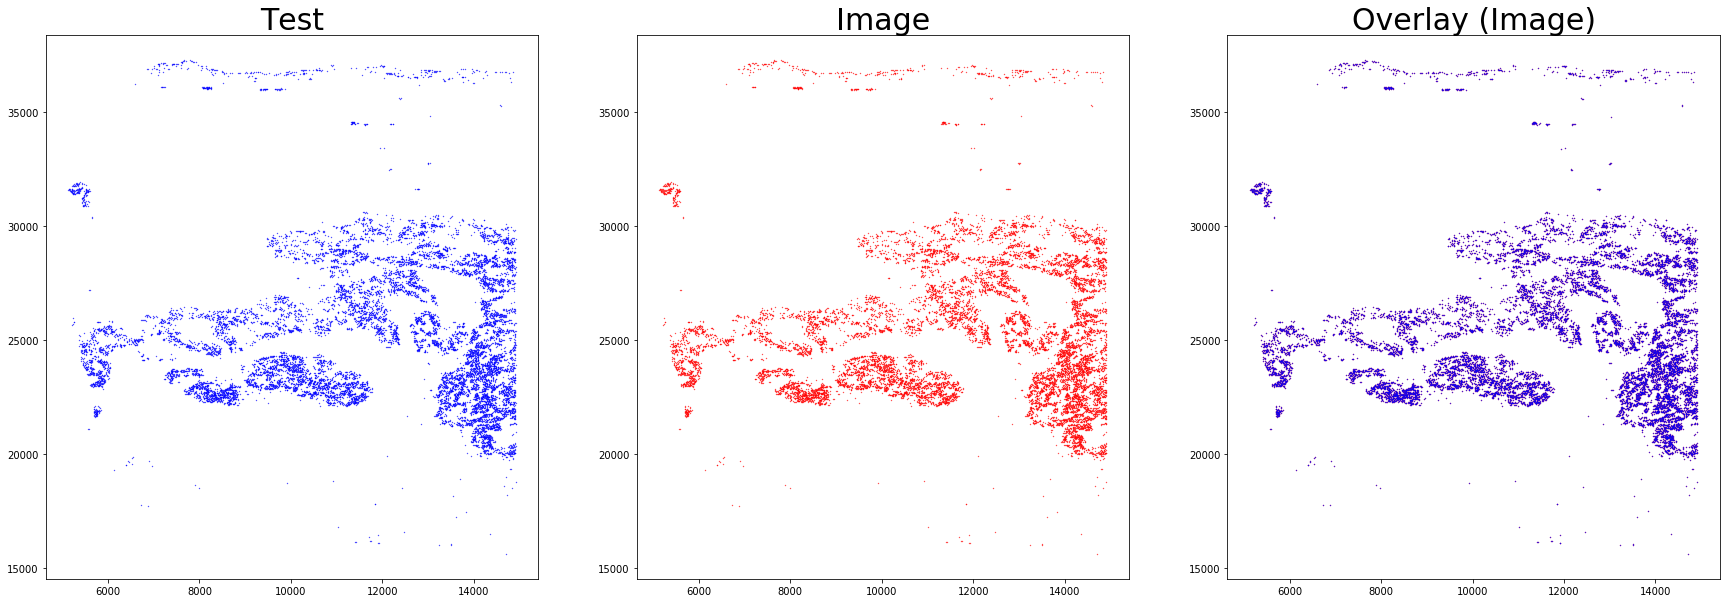

In [95]:
convert = lambda x: int(round(x))

def partition(image, tile_size=TILE_SIZE):
    """Divide an image into a (tile_size x tile_size) grid and return the partitioned input."""
    partitioned_image = np.empty((tile_size, tile_size), dtype=object)
    tiles = []

    xMin = image[:,0]
    xMax = image[:,1]
    xAvg = np.mean(np.array([xMin, xMax]), axis=0)
    yMin = image[:,2]
    yMax = image[:,3]
    yAvg = np.mean(np.array([yMin, yMax]), axis=0)

    x_base = min(xMin)
    y_base = min(yMin)

    x_step = convert((max(xMax) - x_base) / (tile_size))
    y_step = convert((max(yMax) - y_base) / (tile_size))
    
    while (x_step * tile_size) <= max(xMax):
        x_step = x_step + 1
        
    while (y_step * tile_size) <= max(yMax):
        y_step = y_step + 1
    
    print("x_base: ", x_base, ", y_base: ", y_base)
    print("x_step: ", x_step, ", y_step: ", y_step)
        
    for i in tqdm(range(tile_size)):
        for j in range(tile_size):
            x_left = x_base + (x_step * i)
            y_low = y_base + (y_step * j)

            x_right = x_base + x_step * (i + 1)
            y_high = y_base + y_step * (j + 1)

            result = ((yAvg >= y_low) & (yAvg < y_high) & (xAvg >= x_left) & (xAvg < x_right)).nonzero()[0]
                
            partitioned_image[i][j] = image[result]
            tiles.append((x_left, y_low, x_right, y_high))
    
    return partitioned_image, tiles        
    
def partition_and_visualise(image, tile_size=TILE_SIZE):
    """Divide an image into a (num_tiles x num_tiles) grid, visualise, and return the partitioned input."""
    partitioned_image = np.empty((tile_size, tile_size), dtype=object)
    draw = []
    tiles = []

    xMin = image[:,0]
    xMax = image[:,1]
    xAvg = np.mean(np.array([xMin, xMax]), axis=0)
    yMin = image[:,2]
    yMax = image[:,3]
    yAvg = np.mean(np.array([yMin, yMax]), axis=0)

    x_base = min(xMin)
    y_base = min(yMin)

    x_step = convert((max(xMax) - x_base) / tile_size)
    y_step = convert((max(yMax) - y_base) / tile_size)
        
    for i in tqdm(range(tile_size)):
        for j in range(tile_size):
            x_left = x_base + (x_step * i)
            y_low = y_base + (y_step * j)

            x_right = x_base + x_step * (i + 1)
            y_high = y_base + y_step * (j + 1)

            result = ((yAvg >= y_low) & (yAvg < y_high) & (xAvg >= x_left) & (xAvg < x_right)).nonzero()[0]

            for coordinates in image[result]:
                draw.append(coordinates)
                
            partitioned_image[i][j] = image[result]
            tiles.append((x_left, y_low, x_right, y_high))
    
    draw = np.asarray(draw)
    
    for item1, item2 in tqdm(zip(draw, image)):
        assert(item1.shape == item2.shape)
        assert(item1[:] in image)
        assert(item1[:] in draw)
        assert(item2[:] in image)
        assert(item2[:] in draw)
                    
    draw_xAvg = np.mean(np.array([draw[:,0], draw[:,1]]), axis=0)
    draw_yAvg = np.mean(np.array([draw[:,2], draw[:,3]]), axis=0)

    image_xAvg = np.mean(np.array([image[:,0], image[:,1]]), axis=0)
    image_yAvg = np.mean(np.array([image[:,2], image[:,3]]), axis=0)    

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

    ax1.set_title('Test', fontsize=30)
    ax1.scatter(draw_xAvg, draw_yAvg, s=0.1, c='b')
    
    ax2.set_title('Image', fontsize=30)
    ax2.scatter(image_xAvg, image_yAvg, s=0.1, c='r')

    ax3.set_title('Overlay (Image)', fontsize=30)
    ax3.scatter(image_xAvg, image_yAvg, s=0.1, c='r')
    ax3.scatter(draw_xAvg, draw_yAvg, s=0.1, c='b')

    plt.show()
                
    return partitioned_image, tiles

partitioned_cancer_cells, windows = partition_and_visualise(cancer_cells)

In [11]:
# total = 0
# for row in range(20):
#     for col in range(20):
#         total += partitioned_cancer_cells[row][col].shape[0]
# print(total)

In [93]:
import Cluster

In [94]:
import unittest

# Test cases for clustering algorithm

# Tests need to cover:

## References v values (want to minimise memory duplication but maintain correctness)
## - E.g. want cells in tile dict to reference a Cluster, not duplicate it by value!

## Make sure that current_tile is outwardly traversed backwards and when checking neighbours iterates forwards
## - Need to check that we get the expected savings. Don't want to traverse right but include redundant cells!

## Check the method(s) associated with 'already_in_cluster()'

## Check the method(s) associated with initialising clusters

## Check neighbour retrieval gets expected results
## - E.g. does not include current_cell
## - E.g. does include those already in same cluster
## - E.g. does not include any cell beyond distance d of current_cell
## - E.g. does not include any cell already accounted for

## Check case where a neighbour is not in a cluster
## - i.e. cluster updates correctly, tile's dict updates correctly

## Check case where a neighbour is in same cluster as current_cell
## - i.e. no change occurs

## Check case where a neighbour is in another cluster
## - E.g. in smaller cluster (should be subsumed)
## - E.g. in same-sized cluster (should be subsumed)
## - E.g. in larger cluster (should subsume current_cell's cluster)

## Check that subsumed cluster is deleted and removed altogether
## - i.e. from tile's dict altogether (check for multiple references that it is completely gone)

## Check cases involving other tiles (yet to implement this)
## - i.e. do not search other tile if too far away from it
## - i.e. search over in one tile
## - i.e. search over in more than one tile

### Want lists of examples and expected outputs/results.

# inputs = {
#     "one_cell_one_bud": (np.array([[50, 53, 50, 53],
#                                   [70, 73, 70, 73]]), 1)
# }

# expecs = {
#     "one_cell_one_bud": ()
# }

# names = ["one_cell_one_bud"]

def initialise_clusters(n):
    image_clusters = np.empty((n, n), dtype=object)

    for i in range(n):
        for j in range(n):
            image_clusters[i][j] = {}

    return image_clusters

class myTest(unittest.TestCase):

    def test_create_cluster_fail_if_invalid_args(self):
        cell = None
        tile = None
        index = None
        with self.assertRaises(TypeError):
            Cluster.create_cluster(cell, tile, index)

        cell = np.array([0, 3, 0, 3])

        with self.assertRaises(TypeError):
            Cluster.create_cluster(cell, tile, index)  # Still fails, as None is not indexable
        
    def test_create_cluster_init_not_none(self):
        cell = np.array([0, 3, 0, 3])
        cell_key = (0, 3, 0, 3)
        tile = {}
        index = (0, 0)
        Cluster.create_cluster(cell, tile, index)
        self.assertTrue(tile[cell_key].cells is not None)
        self.assertTrue(tile[cell_key].tiles is not None)

    def test_create_cluster_init_correct_cells(self):
        expected = [np.array([0, 3, 0, 3])]
        cell = np.array([0, 3, 0, 3])
        cell_key = (0, 3, 0, 3)
        tile = {}
        index = (0, 0)
        Cluster.create_cluster(cell, tile, index)
        for c1, c2 in zip(expected, tile[cell_key].cells):
            self.assertTrue(c1[0] == c2[0])
            self.assertTrue(c1[1] == c2[1])
            self.assertTrue(c1[2] == c2[2])
            self.assertTrue(c1[3] == c2[3])

    def test_create_cluster_init_correct_tiles(self):
        expected = [(0, 0)]
        cell = np.array([0, 3, 0, 3])
        cell_key = (0, 3, 0, 3)
        tile = {}
        index = (0, 0)
        Cluster.create_cluster(cell, tile, index)
        for t1, t2 in zip(expected, tile[cell_key].tiles):
            self.assertTrue(t1[0] == t2[0])
            self.assertTrue(t1[1] == t2[1])

    def test_update_winning_cluster(self):
        pass
        
        
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.010s

OK


In [14]:
# Example cases for clustering algorithm

100%|██████████| 3/3 [00:00<00:00, 1822.55it/s]

x_base:  0 , y_base:  0
x_step:  169 , y_step:  169


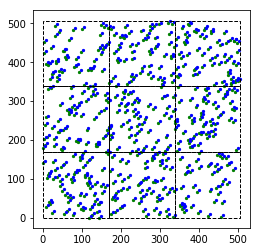

[[ {(95, 100, 156, 161): <Cluster.Cluster object at 0x12a3b8da0>, (91, 96, 34, 39): <Cluster.Cluster object at 0x12a3b83c8>, (62, 67, 17, 22): <Cluster.Cluster object at 0x12a3b8470>, (48, 53, 70, 75): <Cluster.Cluster object at 0x127446ba8>, (65, 70, 53, 58): <Cluster.Cluster object at 0x12926cf98>, (119, 124, 102, 107): <Cluster.Cluster object at 0x12a3b8b38>, (27, 32, 143, 148): <Cluster.Cluster object at 0x1285c62e8>, (102, 107, 20, 25): <Cluster.Cluster object at 0x12a2b9e10>, (140, 145, 14, 19): <Cluster.Cluster object at 0x12a60c470>, (26, 31, 99, 104): <Cluster.Cluster object at 0x12a3b8b00>, (44, 49, 81, 86): <Cluster.Cluster object at 0x127446ba8>, (133, 138, 44, 49): <Cluster.Cluster object at 0x12a2b9630>, (121, 126, 152, 157): <Cluster.Cluster object at 0x1285c6630>, (82, 87, 117, 122): <Cluster.Cluster object at 0x128c4aa58>, (160, 165, 80, 85): <Cluster.Cluster object at 0x12a3b8a20>, (10, 15, 103, 108): <Cluster.Cluster object at 0x12a2b9e48>, (94, 99, 60, 65): <Cluster

<Cluster.Cluster object at 0x129ef5d68>  ***
<Cluster.Cluster object at 0x129ef5d30>  ***
<Cluster.Cluster object at 0x129ef5358>  ***
<Cluster.Cluster object at 0x129ef5f28>  ***
<Cluster.Cluster object at 0x129ef5ac8>  ***
<Cluster.Cluster object at 0x129bde940>  ***
<Cluster.Cluster object at 0x129bded68>  ***
<Cluster.Cluster object at 0x129bdeb00>  ***
<Cluster.Cluster object at 0x129bdebe0>  ***
<Cluster.Cluster object at 0x129bdecf8>  ***
<Cluster.Cluster object at 0x127ad4358>  ***
<Cluster.Cluster object at 0x129bde9e8>  ***
<Cluster.Cluster object at 0x129bdeb38>  ***
<Cluster.Cluster object at 0x129bdea90>  ***
<Cluster.Cluster object at 0x129bdeda0>  ***
<Cluster.Cluster object at 0x129bdef60>  ***
<Cluster.Cluster object at 0x129bdee10>  ***
<Cluster.Cluster object at 0x129bde8d0>  ***
<Cluster.Cluster object at 0x129bdeac8>  ***
<Cluster.Cluster object at 0x127ad4198>  ***
<Cluster.Cluster object at 0x129bdef28>  ***
<Cluster.Cluster object at 0x129bdeeb8>  ***
<Cluster.C

In [15]:
NUM_POINTS = 500

check_again = False

if not check_again:
    random_xMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
    random_xMax = np.copy(random_xMin) + 5
    random_yMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
    random_yMax = np.copy(random_yMin) + 5
    random_points = np.stack((random_xMin, random_xMax, random_yMin, random_yMax), 0).transpose()
    check_again = True

partitioned_random_points, windows_list = partition(random_points, tile_size=3)

partitioned_total = 0
for i in range(3):
    for j in range(3):
        partitioned_total += partitioned_random_points[i][j].shape[0]

# assert(partitioned_total == NUM_POINTS)

fig = plt.figure()

ax1 = fig.add_subplot(111, aspect='equal')

ax1.scatter(random_points[:,0], random_points[:,2], s=5, c='g')
ax1.scatter(random_points[:,1], random_points[:,3], s=5, c='b')

for window in windows_list:
    xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
    ax1.add_patch(
        patches.Rectangle(
            (xMin, yMin),   # (x,y)
            xMax - xMin,    # width
            yMax - yMin,    # height
            linestyle='--',
            fill=False
        )
    )

plt.show()

windows = np.array(windows_list).reshape((3, 3, 4))

result = Cluster.test_cluster_algorithm(partitioned_random_points, 3, windows)

print(result)

dups = []
histogram = np.zeros(21, dtype=np.uint32)

for i in range(3):
    for j in range(3):
        for key, value in result[i][j].items():
            if value not in dups:
                dups.append(value)
        
print("dups (length is %d):" % len(dups))
total_cluster_cells = 0
for i in dups:
    print(i, " ***")
    if i is None:
        raise TypeError
    value = len(i.cells)
    total_cluster_cells += len(i.cells)
    if value > 20:
        histogram[20] += 1
    else:
        histogram[value - 1] += 1

print(total_cluster_cells)
print(histogram)
    
######################################################################

# for cluster in dups:
#     cluster_points_xMin = np.array([item[0] for item in cluster.cells])
#     cluster_points_xMax = np.array([item[1] for item in cluster.cells])
#     cluster_points_yMin = np.array([item[2] for item in cluster.cells])
#     cluster_points_yMax = np.array([item[3] for item in cluster.cells])
#     print("cluster.cells.length: ", len(cluster.cells))

#     fig = plt.figure()
#     ax1 = fig.add_subplot(111, aspect='equal')

#     ax1.scatter(cluster_points_xMin, cluster_points_yMin, s=5, c="b")
#     ax1.scatter(cluster_points_xMax, cluster_points_yMax, s=5, c="b")

#     for window in windows_list:
#         xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
#         ax1.add_patch(
#             patches.Rectangle(
#                 (xMin, yMin),   # (x,y)
#                 xMax - xMin,    # width
#                 yMax - yMin,    # height
#                 linestyle='--',
#                 fill=False
#             )
#         )
#     plt.show()

######################################################################

total = 0
for i in range(3):
    for j in range(3):
        assert(partitioned_random_points[i][j].shape[0] == len(result[i][j]))
        total += len(result[i][j])

print("total:", total)
# assert(total == NUM_POINTS)

In [97]:
windows = np.array(windows).reshape((20, 20, 4))

result = Cluster.test_cluster_algorithm(partitioned_cancer_cells, 20, windows)

print(result)

[[{} {} {} {} {}
  {(5558, 5604, 21081, 21141): <Cluster.Cluster object at 0x137605ef0>, (5538, 5580, 21073, 21107): <Cluster.Cluster object at 0x137605ef0>}
  {(5594, 5624, 22995, 23025): <Cluster.Cluster object at 0x1375e0b38>}
  {(5496, 5510, 23881, 23893): <Cluster.Cluster object at 0x137618080>, (5598, 5620, 23553, 23571): <Cluster.Cluster object at 0x137605550>, (5564, 5594, 24021, 24049): <Cluster.Cluster object at 0x137618240>, (5496, 5530, 23817, 23853): <Cluster.Cluster object at 0x137618080>, (5476, 5496, 24045, 24065): <Cluster.Cluster object at 0x1375e7c18>, (5526, 5562, 23747, 23779): <Cluster.Cluster object at 0x137618080>, (5490, 5530, 23723, 23757): <Cluster.Cluster object at 0x137618080>, (5518, 5558, 23505, 23549): <Cluster.Cluster object at 0x137605550>, (5556, 5594, 23815, 23853): <Cluster.Cluster object at 0x137618080>, (5400, 5444, 24121, 24213): <Cluster.Cluster object at 0x137618cf8>, (5580, 5618, 23765, 23795): <Cluster.Cluster object at 0x137618080>, (5524, 5

In [98]:
dups = []
histogram = np.zeros(21, dtype=np.uint32)

for i in range(20):
    for j in range(20):
        for key, value in result[i][j].items():
            if value not in dups:
                dups.append(value)
        
print("dups (length is %d):" % len(dups))
total_cluster_cells = 0
for i in dups:
    print(i, " ***")
    if i is None:
        raise TypeError
    value = len(i.cells)
    total_cluster_cells += len(i.cells)
    if value > 20:
        histogram[20] += 1
    else:
        histogram[value - 1] += 1

print(total_cluster_cells)
print(histogram)

dups (length is 2647):
<Cluster.Cluster object at 0x137605ef0>  ***
<Cluster.Cluster object at 0x1375e0b38>  ***
<Cluster.Cluster object at 0x137618080>  ***
<Cluster.Cluster object at 0x137605550>  ***
<Cluster.Cluster object at 0x137618240>  ***
<Cluster.Cluster object at 0x1375e7c18>  ***
<Cluster.Cluster object at 0x137618cf8>  ***
<Cluster.Cluster object at 0x137618048>  ***
<Cluster.Cluster object at 0x1375e7f28>  ***
<Cluster.Cluster object at 0x1375e7ef0>  ***
<Cluster.Cluster object at 0x1375e75f8>  ***
<Cluster.Cluster object at 0x1375e73c8>  ***
<Cluster.Cluster object at 0x1375e7f60>  ***
<Cluster.Cluster object at 0x137730cf8>  ***
<Cluster.Cluster object at 0x1375f1278>  ***
<Cluster.Cluster object at 0x1375e7160>  ***
<Cluster.Cluster object at 0x1375f1fd0>  ***
<Cluster.Cluster object at 0x1375e7b00>  ***
<Cluster.Cluster object at 0x1375f15f8>  ***
<Cluster.Cluster object at 0x1375e7358>  ***
<Cluster.Cluster object at 0x1375e77b8>  ***
<Cluster.Cluster object at 0x137

<Cluster.Cluster object at 0x1375d65f8>  ***
<Cluster.Cluster object at 0x1375d6160>  ***
<Cluster.Cluster object at 0x1375d6748>  ***
<Cluster.Cluster object at 0x1375d6518>  ***
<Cluster.Cluster object at 0x1375d6630>  ***
<Cluster.Cluster object at 0x1375d6a20>  ***
<Cluster.Cluster object at 0x1375d6978>  ***
<Cluster.Cluster object at 0x1375d67f0>  ***
<Cluster.Cluster object at 0x1375d67b8>  ***
<Cluster.Cluster object at 0x1375d62e8>  ***
<Cluster.Cluster object at 0x1375d6ef0>  ***
<Cluster.Cluster object at 0x1375d6400>  ***
<Cluster.Cluster object at 0x1375d6c88>  ***
<Cluster.Cluster object at 0x1375d63c8>  ***
<Cluster.Cluster object at 0x1375d6198>  ***
<Cluster.Cluster object at 0x1375d6cc0>  ***
<Cluster.Cluster object at 0x1375d65c0>  ***
<Cluster.Cluster object at 0x1375d6080>  ***
<Cluster.Cluster object at 0x1375d2550>  ***
<Cluster.Cluster object at 0x1301bce48>  ***
<Cluster.Cluster object at 0x1301bc978>  ***
<Cluster.Cluster object at 0x1301bc5c0>  ***
<Cluster.C

<Cluster.Cluster object at 0x13748ee80>  ***
<Cluster.Cluster object at 0x13748f908>  ***
<Cluster.Cluster object at 0x13748f550>  ***
<Cluster.Cluster object at 0x13748f710>  ***
<Cluster.Cluster object at 0x13748fac8>  ***
<Cluster.Cluster object at 0x13748eb70>  ***
<Cluster.Cluster object at 0x13748e780>  ***
<Cluster.Cluster object at 0x13748ebe0>  ***
<Cluster.Cluster object at 0x13748e908>  ***
<Cluster.Cluster object at 0x13748ed68>  ***
<Cluster.Cluster object at 0x13748eb38>  ***
<Cluster.Cluster object at 0x13748e7b8>  ***
<Cluster.Cluster object at 0x137487208>  ***
<Cluster.Cluster object at 0x13748e320>  ***
<Cluster.Cluster object at 0x13748e748>  ***
<Cluster.Cluster object at 0x13748e6d8>  ***
<Cluster.Cluster object at 0x13748e6a0>  ***
<Cluster.Cluster object at 0x13748e710>  ***
<Cluster.Cluster object at 0x137485cf8>  ***
<Cluster.Cluster object at 0x13748e588>  ***
<Cluster.Cluster object at 0x13748e470>  ***
<Cluster.Cluster object at 0x13748e940>  ***
<Cluster.C

<Cluster.Cluster object at 0x13746ebe0>  ***
<Cluster.Cluster object at 0x13746e940>  ***
<Cluster.Cluster object at 0x13746e9b0>  ***
<Cluster.Cluster object at 0x13746eb38>  ***
<Cluster.Cluster object at 0x13746e908>  ***
<Cluster.Cluster object at 0x13746e780>  ***
<Cluster.Cluster object at 0x13746ee80>  ***
<Cluster.Cluster object at 0x137467b70>  ***
<Cluster.Cluster object at 0x13746e4e0>  ***
<Cluster.Cluster object at 0x13746e978>  ***
<Cluster.Cluster object at 0x13746e7f0>  ***
<Cluster.Cluster object at 0x13746e5c0>  ***
<Cluster.Cluster object at 0x13746e4a8>  ***
<Cluster.Cluster object at 0x13746cc18>  ***
<Cluster.Cluster object at 0x13746e2b0>  ***
<Cluster.Cluster object at 0x13746e128>  ***
<Cluster.Cluster object at 0x13746ce80>  ***
<Cluster.Cluster object at 0x13746e320>  ***
<Cluster.Cluster object at 0x13746e160>  ***
<Cluster.Cluster object at 0x1374676d8>  ***
<Cluster.Cluster object at 0x13746e0f0>  ***
<Cluster.Cluster object at 0x13746e0b8>  ***
<Cluster.C

<Cluster.Cluster object at 0x137450ba8>  ***
<Cluster.Cluster object at 0x13745bb38>  ***
<Cluster.Cluster object at 0x137450390>  ***
<Cluster.Cluster object at 0x13744fbe0>  ***
<Cluster.Cluster object at 0x13744fa90>  ***
<Cluster.Cluster object at 0x13744ff60>  ***
<Cluster.Cluster object at 0x137450160>  ***
<Cluster.Cluster object at 0x13744fe48>  ***
<Cluster.Cluster object at 0x137450828>  ***
<Cluster.Cluster object at 0x137450400>  ***
<Cluster.Cluster object at 0x1374507f0>  ***
<Cluster.Cluster object at 0x137450978>  ***
<Cluster.Cluster object at 0x137450588>  ***
<Cluster.Cluster object at 0x137450748>  ***
<Cluster.Cluster object at 0x1374507b8>  ***
<Cluster.Cluster object at 0x13744fcf8>  ***
<Cluster.Cluster object at 0x13744fef0>  ***
<Cluster.Cluster object at 0x13744fc18>  ***
<Cluster.Cluster object at 0x137450128>  ***
<Cluster.Cluster object at 0x13744fcc0>  ***
<Cluster.Cluster object at 0x13744fc88>  ***
<Cluster.Cluster object at 0x1374500f0>  ***
<Cluster.C

In [16]:
def cluster(partitioned_image):
    
    # image_clusters will be an array of dicts
    # Each dict will contain an arbitrary number of Cluster objects
    # Each Cluster object will contain a list of cells as well as optionally the tiles it overlaps.
    # If a Cluster overlaps more than one tile, state all tiles that it overlaps by (i, j)
    # and add that Cluster to the dict of that tile.
    # If there is a collision between two clusters, have the larger of the two 'subsume' the other
    # and remove the now-empty cluster object from its tile. This extends to 3+ clusters as well.
    
    # More precisely, to subsume, check whether the len(cells) of one cluster is >= the other.
    # The winner takes all the cells of that losing cluster (which may include current cell).
    # Then remove that cluster from the dict of the tile it is in.
    
    image_clusters = np.empty((TILE_SIZE, TILE_SIZE), dtype=object)
    
    for i in range(TILE_SIZE):
        for j in range(TILE_SIZE):
            for cell in partitioned_image[i][j]:
                pass

In [17]:
print(333333**2)

111110888889


In [18]:
print(sum(range(333333)) * 2)

111110555556
